### Team members

1. Amirhossein Soltani
2. Moein Taherkhani

In [21]:
import numpy as np
import os
import torch
import torch.nn as nn
import yaml
from pathlib import Path
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics.classification import ConfusionMatrix
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Downloading the dataset


In [5]:

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


### Dataset inspection

In [29]:
print(f"# Images Train: {len(train_dataset)}")
print(f"# Images Test:  {len(test_dataset)}")

# Images Train: 50000
# Images Test:  10000


In [30]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 32, 32])
Label: 6


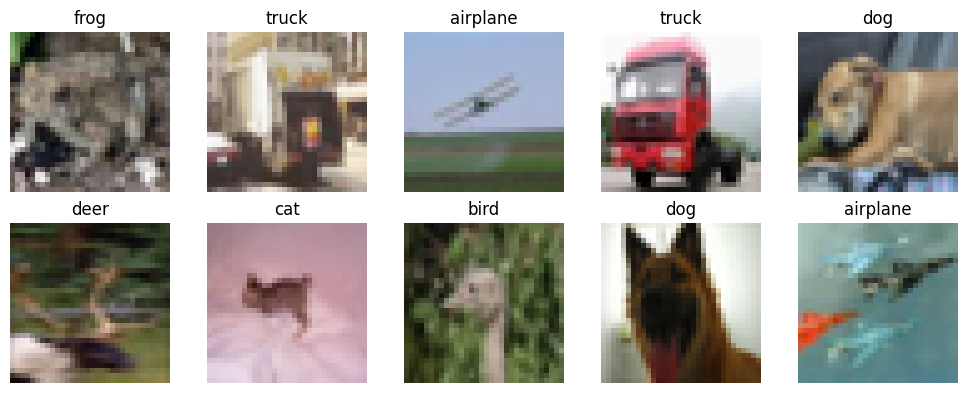

In [11]:
import matplotlib.pyplot as plt


classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

N_IMGS = 8
fig, ax = plt.subplots(2,5)
fig.set_size_inches(10, 4)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i in range(2):
    for j in range (5):
        id = np.random.randint(0,len(train_dataset),1)[0]
        img = train_dataset[id][0].numpy().transpose((1,2,0))
        ax[i,j].imshow(img)
        ax[i,j].set_title(f"{classes[train_dataset[id][1]]}")
        ax[i,j].axis("off")
plt.tight_layout()
plt.show()


### Training engines

In [32]:
log_dict = {'Training_loss' : [] ,'Validation_loss' : [] }

def trainer(model, criterion, optimizer, imgs, labels) -> float:
    model.train()

    # forward pass
    if model.model_type == "MLP":
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
    else:
        preds = model(imgs)

    loss = criterion(preds, labels)
    log_dict['Training_loss'].append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def validator(model, val_loader, criterion, epoch ) -> float:
    model.eval()
    val_loss = 0
    with torch.no_grad():
        print("##### Validating ... ####")

        for val_imgs, val_labels in val_loader:
            val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)

            if model.model_type == "MLP":
                flattened_val_imgs = val_imgs.flatten(start_dim=1)
                val_preds = model(flattened_val_imgs)
            else: 
                val_preds = model(val_imgs)

            val_loss += criterion(val_preds, val_labels).item()
    
    avg_val_loss = val_loss / len(val_loader)
    log_dict['Validation_loss'].append(avg_val_loss)
    print(f"\nValidation loss after epoch {epoch + 1}: {avg_val_loss:.5f}\n")
    return avg_val_loss


### Warm up learning rate


In [34]:
def warmup_lr(optimizer, current_epoch, warmup_epochs, target_lr, init_lr=1e-6):
    """
    Adjusting the learning rate using a linear warmup schedule.
    """
    if current_epoch >= warmup_epochs:
        current_lr = target_lr
    else:

        progress = current_epoch / warmup_epochs
        current_lr = init_lr + (target_lr - init_lr) * progress
    
    # Update learning rate 
    for param_group in optimizer.param_groups:
        param_group['lr'] = current_lr
    
    return current_lr


### Training and Validation loop

In [41]:

def train(model : nn.Module, train_loader, val_loader, training_config, use_scheduler = False):

    # Tensorboard log directory
    root = Path("./")
    log_dir = root/'log_dir'
    log_dir = os.path.join(log_dir, training_config['Experiment_name'])

    writer = SummaryWriter(log_dir=log_dir)  
    
    criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
    optimizer = torch.optim.Adam(model.parameters(), lr=training_config['lr'])

    ## Main training loop
    print("##### TRAINING ... ####")

    for epoch in range(training_config['epochs']):
        progress_bar = tqdm(train_loader, total=len(train_loader))

        if use_scheduler: 
            current_lr = warmup_lr(
            optimizer=optimizer,
            current_epoch=epoch,  # assuming epoch is 0-based
            warmup_epochs=25,      # adjust this value as needed
            target_lr=training_config['lr']       # your desired final learning rate
            )
        
        for i, (imgs, labels) in enumerate(progress_bar):
            imgs, labels = imgs.to(device), labels.to(device)
            loss_tr = trainer(model= model, criterion=criterion, optimizer= optimizer, imgs= imgs, labels= labels)

            if(i % 5 == 0 or i == len(train_loader) - 1):
                progress_bar.set_description(f"Epoch {epoch + 1} Batch {i + 1}: loss {loss_tr:.5f}. ")
                
        # Validation every 10 epochs
        if (epoch + 1) % 10 == 0:
            avg_val_loss = validator(model = model, val_loader= val_loader, criterion= criterion, epoch = epoch)
            writer.add_scalar('Loss/val', avg_val_loss, epoch)

        writer.add_scalar('Loss/train', loss_tr, epoch)
        writer.add_scalar('Learning_rate', current_lr, epoch)

    writer.close()


### EVALUATION

In [8]:
def evaluate (model , dataloader ):
    print("##### EVALUATION ... ####")
    model.eval()
    n_correct = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
        for i, (imgs, labels) in progress_bar: 
            imgs, labels = imgs.to(device), labels.to(device)

            if model.model_type == "MLP":
                flattened_imgs = imgs.flatten(start_dim=1)
                preds = model(flattened_imgs)
            else:
                preds = model(imgs)

            pred_labels = torch.argmax(torch.softmax(preds, dim=-1), dim=-1)
            cur_correct = len(torch.where(pred_labels == labels)[0])
            n_correct = n_correct + cur_correct

            all_preds.append(pred_labels)
            all_labels.append(torch.as_tensor(labels, device=device))

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    accuracy = n_correct / len(test_dataset) * 100
    print(f"Test accuracy: {round(accuracy,2)}%") 

    return all_preds, all_labels

### Saving the model

In [37]:
def save(model : nn.Module, training_config):
    root = Path("./")
    Experiment = training_config['Experiment_name']
    save_dir = root/'models'/Experiment

    if(not os.path.exists(save_dir)):
        os.makedirs(save_dir,exist_ok=True)
    # savepath = f"{root}/checkpoint_{training_config['Experiment_name']}.pth"

    checkpoint_path = os.path.join(save_dir,f"checkpoint_{training_config['Experiment_name']}.pth")
    torch.save({
                'model_state_dict': model.state_dict(),
                }, checkpoint_path)

    # Save the training configuration for each experiment
    with open(os.path.join(save_dir, "training_config.yaml"), "w") as f:
        yaml.dump(training_config, f)

### Dataloaders

In [9]:
# TODO: CHANGE THIS CONFIGE BEFORE EVERY TRAINING!

training_config = {'BATCH_SIZE' : 1024,
                   'lr' : 1e-4,
                   'epochs' : 100,
                   'Experiment_name': 'Exp6'
                   }

Experiment = training_config['Experiment_name']

# Spliting the training dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=True
    )

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=training_config['BATCH_SIZE'],
    shuffle=False
)

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=False,
        drop_last=True
    )


## `MLP`

In [12]:
class Model(nn.Module):
    
    def __init__(self, input_dim=3072, hidden_dim=1024, output_dim=len(classes), dropout: bool = False, dropout_p: float = 0.5):
        """ Model initializer """
        super().__init__()
        self.model_type = "MLP"
        
        layers = []

        # First layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        if dropout:
            layers.append(nn.Dropout(p=dropout_p))

        # Second layer
        layers.append(nn.Linear(hidden_dim, 512))
        layers.append(nn.ReLU())
        if dropout:
            layers.append(nn.Dropout(p=dropout_p))

        # Third layer
        layers.append(nn.Linear(512, 256))
        layers.append(nn.ReLU())
        if dropout:
            layers.append(nn.Dropout(p=dropout_p))

        # Fourth layer
        layers.append(nn.Linear(256, 128))
        layers.append(nn.ReLU())
        if dropout:
            layers.append(nn.Dropout(p=dropout_p))

        # Output layer (no ReLU or Dropout after this)
        layers.append(nn.Linear(128, output_dim))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        """ Forward pass through the model """
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        return self.layers(x)


### Vanilla MLP (No dropout, no scheduler)

In [12]:
mlp_model = Model(dropout=False).to(device)
summary(mlp_model, input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       3,146,752
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 3,837,066
Trainable params: 3,837,066
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 14.64
Estimated Total Size (MB): 14.68
-------------------------------------

In [13]:
train(model= mlp_model, train_loader= train_loader, val_loader= val_loader, training_config= training_config)

##### TRAINING ... ####


Epoch 10 Batch 40: loss 1.59233. : 100%|██████████| 40/40 [00:01<00:00, 26.32it/s]


##### Validating ... ####

Validation loss after epoch 10: 1.69202



Epoch 20 Batch 40: loss 1.47621. : 100%|██████████| 40/40 [00:01<00:00, 26.90it/s]


##### Validating ... ####

Validation loss after epoch 20: 1.56152



Epoch 30 Batch 40: loss 1.48660. : 100%|██████████| 40/40 [00:01<00:00, 25.99it/s]


##### Validating ... ####

Validation loss after epoch 30: 1.49100



Epoch 40 Batch 40: loss 1.42246. : 100%|██████████| 40/40 [00:01<00:00, 26.83it/s]


##### Validating ... ####

Validation loss after epoch 40: 1.43949



Epoch 50 Batch 40: loss 1.16488. : 100%|██████████| 40/40 [00:01<00:00, 26.88it/s]


##### Validating ... ####

Validation loss after epoch 50: 1.41187



Epoch 60 Batch 40: loss 1.08267. : 100%|██████████| 40/40 [00:01<00:00, 26.85it/s]


##### Validating ... ####

Validation loss after epoch 60: 1.37226



Epoch 70 Batch 40: loss 0.95403. : 100%|██████████| 40/40 [00:01<00:00, 26.92it/s]


##### Validating ... ####

Validation loss after epoch 70: 1.37973



Epoch 80 Batch 40: loss 1.10862. : 100%|██████████| 40/40 [00:01<00:00, 26.99it/s]


##### Validating ... ####

Validation loss after epoch 80: 1.34192



Epoch 90 Batch 40: loss 0.99158. : 100%|██████████| 40/40 [00:01<00:00, 26.90it/s]


##### Validating ... ####

Validation loss after epoch 90: 1.36775



Epoch 100 Batch 40: loss 1.22702. : 100%|██████████| 40/40 [00:01<00:00, 26.92it/s]


##### Validating ... ####

Validation loss after epoch 100: 1.38691



In [14]:
evaluate(model= mlp_model, dataloader= eval_loader)

##### EVALUATION ... ####


100%|██████████| 9/9 [00:00<00:00, 27.06it/s]

Test accuracy: 49.31%


In [15]:
save(model = mlp_model, training_config= training_config)

### MLP with dropout

In [18]:
mlp_model_dropout = Model(dropout=True).to(device)
summary(mlp_model_dropout, input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       3,146,752
              ReLU-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
             ReLU-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 3,837,066
Trainable param

In [19]:
train(model= mlp_model_dropout, train_loader= train_loader, val_loader= val_loader, training_config= training_config)

##### TRAINING ... ####


Epoch 10 Batch 32: loss 2.03538. : 100%|██████████| 32/32 [00:01<00:00, 26.51it/s]


##### Validating ... ####

Validation loss after epoch 10: 1.85142



Epoch 20 Batch 32: loss 1.83567. : 100%|██████████| 32/32 [00:01<00:00, 26.54it/s]


##### Validating ... ####

Validation loss after epoch 20: 1.70767



Epoch 30 Batch 32: loss 1.60019. : 100%|██████████| 32/32 [00:01<00:00, 26.50it/s]


##### Validating ... ####

Validation loss after epoch 30: 1.61166



Epoch 40 Batch 32: loss 1.57280. : 100%|██████████| 32/32 [00:01<00:00, 26.55it/s]


##### Validating ... ####

Validation loss after epoch 40: 1.55734



Epoch 50 Batch 32: loss 1.55094. : 100%|██████████| 32/32 [00:01<00:00, 26.53it/s]


##### Validating ... ####

Validation loss after epoch 50: 1.50457



Epoch 60 Batch 32: loss 1.55437. : 100%|██████████| 32/32 [00:01<00:00, 25.21it/s]


##### Validating ... ####

Validation loss after epoch 60: 1.46993



Epoch 70 Batch 32: loss 1.45743. : 100%|██████████| 32/32 [00:01<00:00, 26.54it/s]


##### Validating ... ####

Validation loss after epoch 70: 1.44245



Epoch 80 Batch 32: loss 1.36851. : 100%|██████████| 32/32 [00:01<00:00, 26.48it/s]


##### Validating ... ####

Validation loss after epoch 80: 1.42280



Epoch 90 Batch 32: loss 1.34933. : 100%|██████████| 32/32 [00:01<00:00, 26.48it/s]


##### Validating ... ####

Validation loss after epoch 90: 1.40765



Epoch 100 Batch 32: loss 1.38891. : 100%|██████████| 32/32 [00:01<00:00, 26.44it/s]


##### Validating ... ####

Validation loss after epoch 100: 1.38668



In [20]:
evaluate(model= mlp_model_dropout, dataloader= eval_loader)

##### EVALUATION ... ####


100%|██████████| 9/9 [00:00<00:00, 25.99it/s]

Test accuracy: 46.79%


In [21]:
save(model = mlp_model_dropout, training_config= training_config)

### `CNN`

In [13]:
class CNNModel(nn.Module):
    ''' 
    Inspired by https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch
    '''
    def __init__(self, use_dropout=False):
        super().__init__()
        self.use_dropout = use_dropout
        
        def maybe_dropout(p):
            return nn.Dropout(p) if self.use_dropout else nn.Identity()
        
        self.network = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            maybe_dropout(0.5),

            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            maybe_dropout(0.5),

            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            maybe_dropout(0.5),

            # Fully Connected
            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            maybe_dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            maybe_dropout(0.5),
            nn.Linear(512, 10)
        )

        self.model_type = "CNN"

    def forward(self, x):
        return self.network(x)


### Vanilla CNN (No dropout/scheduler)

In [ ]:
cnn_model = CNNModel(use_dropout=False).to(device)
summary(cnn_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
          Identity-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
         Identity-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

In [16]:
train(model= cnn_model, train_loader= train_loader, val_loader= val_loader, training_config= training_config)

##### TRAINING ... ####


Epoch 10 Batch 32: loss 1.55543. : 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]


##### Validating ... ####

Validation loss after epoch 10: 1.49345



Epoch 20 Batch 32: loss 1.20532. : 100%|██████████| 32/32 [00:04<00:00,  7.36it/s]


##### Validating ... ####

Validation loss after epoch 20: 1.32006



Epoch 30 Batch 32: loss 1.25034. : 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]


##### Validating ... ####

Validation loss after epoch 30: 1.21121



Epoch 40 Batch 32: loss 0.99746. : 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]


##### Validating ... ####

Validation loss after epoch 40: 1.21894



Epoch 50 Batch 32: loss 0.85670. : 100%|██████████| 32/32 [00:04<00:00,  7.36it/s]


##### Validating ... ####

Validation loss after epoch 50: 1.11642



Epoch 60 Batch 32: loss 0.85770. : 100%|██████████| 32/32 [00:04<00:00,  7.26it/s]


##### Validating ... ####

Validation loss after epoch 60: 1.11282



Epoch 70 Batch 32: loss 0.65389. : 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]


##### Validating ... ####

Validation loss after epoch 70: 1.16243



Epoch 80 Batch 32: loss 0.52912. : 100%|██████████| 32/32 [00:04<00:00,  7.36it/s]


##### Validating ... ####

Validation loss after epoch 80: 1.29361



Epoch 90 Batch 32: loss 0.42099. : 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]


##### Validating ... ####

Validation loss after epoch 90: 1.60678



Epoch 100 Batch 32: loss 0.19581. : 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]


##### Validating ... ####

Validation loss after epoch 100: 1.89305



In [17]:
evaluate(model= cnn_model, dataloader= eval_loader)

##### EVALUATION ... ####


100%|██████████| 9/9 [00:00<00:00, 14.68it/s]

Test accuracy: 55.62%


In [18]:
save(model= cnn_model, training_config= training_config)

### CNN with dropout

In [13]:
cnn_model_dropout = CNNModel(use_dropout=True).to(device)
summary(cnn_model_dropout, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
           Dropout-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
          Dropout-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

In [14]:
train(model= cnn_model_dropout, train_loader= train_loader, val_loader= val_loader, training_config= training_config)

##### TRAINING ... ####


Epoch 10 Batch 40: loss 1.55694. : 100%|██████████| 40/40 [00:05<00:00,  7.39it/s]


##### Validating ... ####

Validation loss after epoch 10: 1.78320



Epoch 20 Batch 40: loss 1.22449. : 100%|██████████| 40/40 [00:05<00:00,  7.38it/s]


##### Validating ... ####

Validation loss after epoch 20: 1.42794



Epoch 30 Batch 40: loss 1.33675. : 100%|██████████| 40/40 [00:05<00:00,  7.37it/s]


##### Validating ... ####

Validation loss after epoch 30: 1.23735



Epoch 40 Batch 40: loss 1.16324. : 100%|██████████| 40/40 [00:05<00:00,  7.37it/s]


##### Validating ... ####

Validation loss after epoch 40: 1.13307



Epoch 50 Batch 40: loss 1.11590. : 100%|██████████| 40/40 [00:05<00:00,  7.38it/s]


##### Validating ... ####

Validation loss after epoch 50: 1.01284



Epoch 60 Batch 40: loss 1.01427. : 100%|██████████| 40/40 [00:05<00:00,  7.37it/s]


##### Validating ... ####

Validation loss after epoch 60: 0.93167



Epoch 70 Batch 40: loss 0.77552. : 100%|██████████| 40/40 [00:05<00:00,  7.28it/s]


##### Validating ... ####

Validation loss after epoch 70: 0.87827



Epoch 80 Batch 40: loss 0.83503. : 100%|██████████| 40/40 [00:05<00:00,  7.37it/s]


##### Validating ... ####

Validation loss after epoch 80: 0.81557



Epoch 90 Batch 40: loss 0.75870. : 100%|██████████| 40/40 [00:05<00:00,  7.37it/s]


##### Validating ... ####

Validation loss after epoch 90: 0.77777



Epoch 100 Batch 40: loss 0.62393. : 100%|██████████| 40/40 [00:05<00:00,  7.37it/s]


##### Validating ... ####

Validation loss after epoch 100: 0.74122



In [15]:
evaluate(model= cnn_model_dropout, dataloader= eval_loader)

##### EVALUATION ... ####


100%|██████████| 9/9 [00:00<00:00, 15.01it/s]

Test accuracy: 68.45%


In [16]:
save(model= cnn_model_dropout, training_config= training_config)

# Confusion Matrix

In [34]:
def plot_cm_matrix(preds,labels):
    class_names = classes
    num_classes = len(classes)
    metric = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
    cm = metric(preds, labels)
    
    if not isinstance(preds, np.ndarray):
        preds = preds.cpu().numpy()
    if not isinstance(labels, np.ndarray):
        labels = labels.cpu().numpy()

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Truth", fontsize=14)
    plt.ylabel("Prediction", fontsize=14)
    plt.title("Confusion Matrix", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

### MLP_Vanilla

##### EVALUATION ... ####


100%|██████████| 9/9 [00:02<00:00,  4.46it/s]


Test accuracy: 49.31%


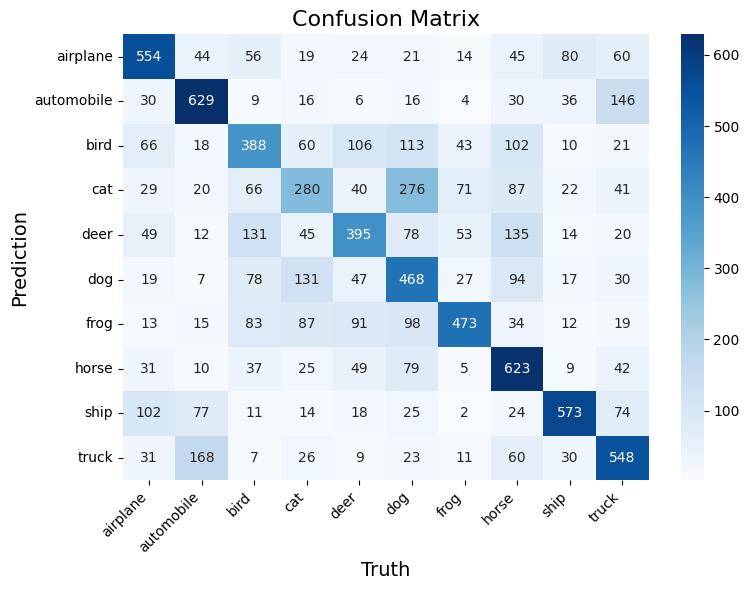

In [35]:
checkpoints_MLP_Vanilla = torch.load("./models/Exp1/checkpoint_Exp1.pth",
                                     map_location=torch.device("cpu") if torch.cuda.is_available() is False else None)
state_dict_MLP_Vanilla = checkpoints_MLP_Vanilla['model_state_dict']
MLP_Vanilla = Model().to(device)
MLP_Vanilla.load_state_dict(state_dict=state_dict_MLP_Vanilla)

preds, labels =  evaluate(MLP_Vanilla, eval_loader)
plot_cm_matrix(preds,labels)


### MLP_Dropout

##### EVALUATION ... ####


100%|██████████| 9/9 [00:01<00:00,  6.50it/s]


Test accuracy: 46.79%


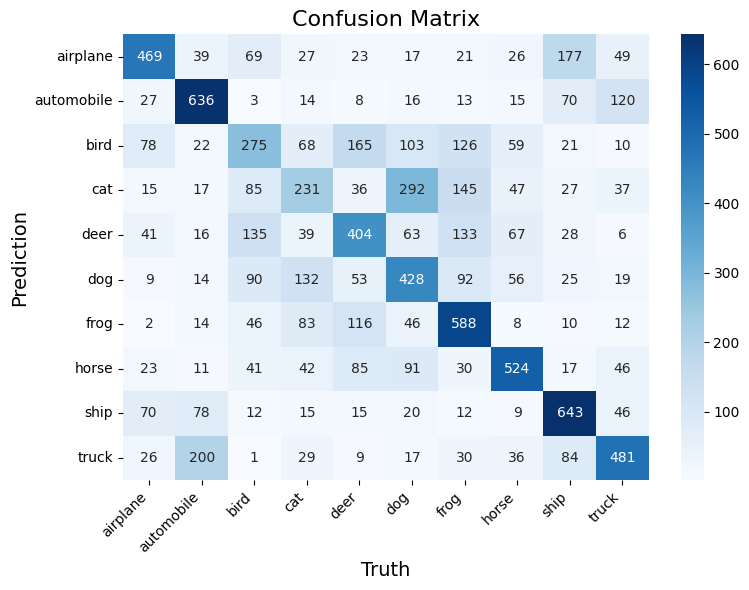

In [36]:
checkpoints_MLP_Dropout = torch.load("./models/Exp2/checkpoint_Exp2.pth",
                                     map_location=torch.device("cpu") if torch.cuda.is_available() is False else None)
                                     
state_dict_MLP_Dropout = checkpoints_MLP_Dropout['model_state_dict']
MLP_Dropout = Model(dropout=True).to(device)
MLP_Dropout.load_state_dict(state_dict=state_dict_MLP_Dropout)


num_classes = len(classes)
metric = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
preds, labels =  evaluate(MLP_Dropout, eval_loader)
cm = metric(preds, labels)
plot_cm_matrix(preds,labels)


## Vanilla CNN

##### EVALUATION ... ####


100%|██████████| 9/9 [00:20<00:00,  2.26s/it]


Test accuracy: 55.62%


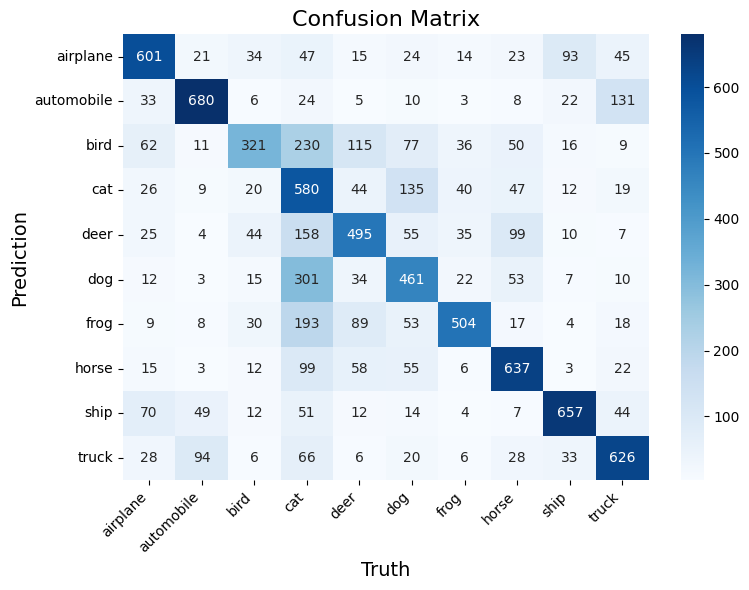

In [38]:
checkpoints_vanilla_cnn = torch.load("./models/Exp3/checkpoint_Exp3.pth",
                                     map_location=torch.device("cpu") if torch.cuda.is_available() is False else None)

state_dict_vanilla_cnn = checkpoints_vanilla_cnn['model_state_dict']
vanilla_cnn = CNNModel().to(device)
vanilla_cnn.load_state_dict(state_dict=state_dict_vanilla_cnn)


num_classes = len(classes)
metric = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
preds, labels =  evaluate(vanilla_cnn, eval_loader)
plot_cm_matrix(preds,labels)

##### EVALUATION ... ####


100%|██████████| 9/9 [00:17<00:00,  1.90s/it]


Test accuracy: 68.45%


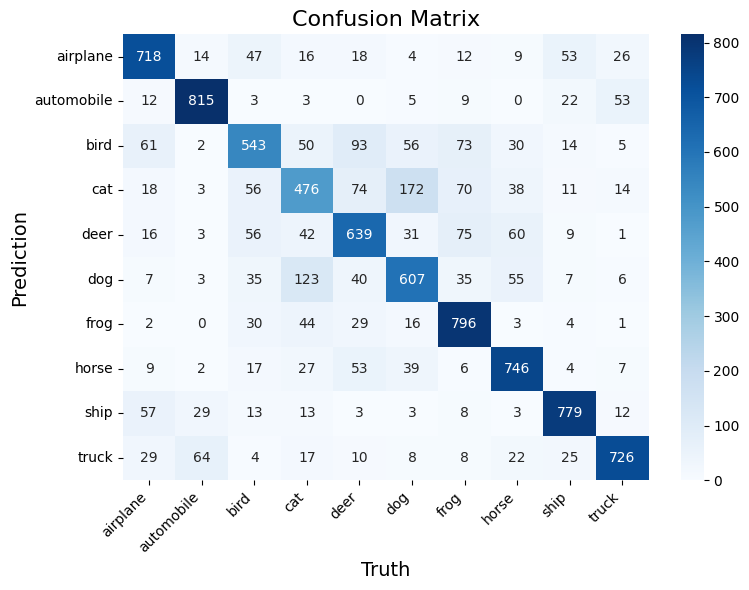

In [ ]:
checkpoints_cnn_dropout = torch.load("./models/Exp4/checkpoint_Exp4.pth",
                                     map_location=torch.device("cpu") if torch.cuda.is_available() is False else None)
state_dict_cnn_dropout = checkpoints_cnn_dropout['model_state_dict']
cnn_dropout = CNNModel(use_dropout=True).to(device)
cnn_dropout.load_state_dict(state_dict=state_dict_cnn_dropout)

num_classes = len(classes)
metric = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
preds, labels =  evaluate(cnn_dropout, eval_loader)
plot_cm_matrix(preds,labels)

### MLP with lr scheduler and deoput

In [44]:
mlp_model_dropout_scheduler = Model(dropout=True).to(device)
train(model= mlp_model_dropout_scheduler, train_loader= train_loader, val_loader= val_loader, training_config= training_config, use_scheduler=True)

##### TRAINING ... ####


Epoch 10 Batch 32: loss 2.07890. : 100%|██████████| 32/32 [00:01<00:00, 25.31it/s]


##### Validating ... ####

Validation loss after epoch 10: 2.07153



Epoch 20 Batch 32: loss 1.87965. : 100%|██████████| 32/32 [00:01<00:00, 24.67it/s]


##### Validating ... ####

Validation loss after epoch 20: 1.82069



Epoch 30 Batch 32: loss 1.74948. : 100%|██████████| 32/32 [00:01<00:00, 25.03it/s]


##### Validating ... ####

Validation loss after epoch 30: 1.69419



Epoch 40 Batch 32: loss 1.69702. : 100%|██████████| 32/32 [00:01<00:00, 25.17it/s]


##### Validating ... ####

Validation loss after epoch 40: 1.58056



Epoch 50 Batch 32: loss 1.64968. : 100%|██████████| 32/32 [00:01<00:00, 24.71it/s]


##### Validating ... ####

Validation loss after epoch 50: 1.53297



Epoch 60 Batch 32: loss 1.56677. : 100%|██████████| 32/32 [00:01<00:00, 24.72it/s]


##### Validating ... ####

Validation loss after epoch 60: 1.48963



Epoch 70 Batch 32: loss 1.45104. : 100%|██████████| 32/32 [00:01<00:00, 23.95it/s]


##### Validating ... ####

Validation loss after epoch 70: 1.45882



Epoch 80 Batch 32: loss 1.52990. : 100%|██████████| 32/32 [00:01<00:00, 25.45it/s]


##### Validating ... ####

Validation loss after epoch 80: 1.43888



Epoch 90 Batch 32: loss 1.35896. : 100%|██████████| 32/32 [00:01<00:00, 24.93it/s]


##### Validating ... ####

Validation loss after epoch 90: 1.42291



Epoch 100 Batch 32: loss 1.34185. : 100%|██████████| 32/32 [00:01<00:00, 25.42it/s]


##### Validating ... ####

Validation loss after epoch 100: 1.40802



In [45]:
evaluate(model= mlp_model_dropout_scheduler, dataloader= eval_loader)

save(model= mlp_model_dropout_scheduler, training_config= training_config)

##### EVALUATION ... ####


100%|██████████| 9/9 [00:00<00:00, 25.23it/s]


Test accuracy: 47.61%


### CNN with lr scheduler and dropout

In [47]:
cnn_model_dropout_scheduler = CNNModel(use_dropout=True).to(device)
train(model= cnn_model_dropout_scheduler, train_loader= train_loader, val_loader= val_loader, training_config= training_config, use_scheduler=True)


##### TRAINING ... ####


Epoch 10 Batch 25: loss 2.00331. : 100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


##### Validating ... ####

Validation loss after epoch 10: 1.98339



Epoch 20 Batch 25: loss 1.66963. : 100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


##### Validating ... ####

Validation loss after epoch 20: 1.67544



Epoch 30 Batch 25: loss 1.52517. : 100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


##### Validating ... ####

Validation loss after epoch 30: 1.45499



Epoch 40 Batch 25: loss 1.41845. : 100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


##### Validating ... ####

Validation loss after epoch 40: 1.34477



Epoch 50 Batch 25: loss 1.34684. : 100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


##### Validating ... ####

Validation loss after epoch 50: 1.31066



Epoch 60 Batch 25: loss 1.25948. : 100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


##### Validating ... ####

Validation loss after epoch 60: 1.18222



Epoch 70 Batch 25: loss 1.12477. : 100%|██████████| 25/25 [00:03<00:00,  6.55it/s]


##### Validating ... ####

Validation loss after epoch 70: 1.09988



Epoch 80 Batch 25: loss 1.07198. : 100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


##### Validating ... ####

Validation loss after epoch 80: 1.03384



Epoch 90 Batch 25: loss 1.01661. : 100%|██████████| 25/25 [00:03<00:00,  6.43it/s]


##### Validating ... ####

Validation loss after epoch 90: 0.97519



Epoch 100 Batch 25: loss 0.93093. : 100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


##### Validating ... ####

Validation loss after epoch 100: 0.93773



In [48]:
evaluate(model= cnn_model_dropout_scheduler, dataloader= eval_loader)

save(model= cnn_model_dropout_scheduler, training_config= training_config)

##### EVALUATION ... ####


100%|██████████| 9/9 [00:00<00:00, 14.38it/s]


Test accuracy: 62.13%
